In [1]:
import numpy as np
from scipy import optimize
import scipy
from sklearn import base, metrics
from sklearn.utils.validation import check_X_y
from classifiers import *
from data_generation import *

## Compare Performance of AT vs Logistic Regression for Different Label Spaces

## Sample Data Generation

In [17]:
d = 2
k = 4
n = 10000
portions = np.array([2, 4, 7, 8])
X,y = generate_linear_complex_data(d, k, n, portions)

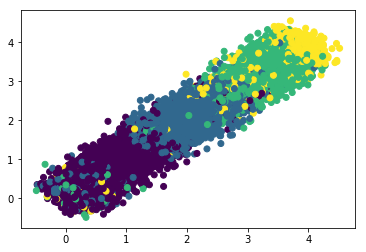

In [18]:
# Visualize Data
from matplotlib import pyplot as plt
plt.scatter([X[:, 0]], [X[:, 1]], c=[y])

## Tests

In [5]:
def mode(array):
    most = max(list(map(array.count, array)))
    return list(set(filter(lambda x: array.count(x) == most, array)))

In [6]:
d = 2
k = 15
n = 10000
portions = np.array([2, 4, 7, 8, 10, 14, 17, 19, 23, 26, 28, 30, 33, 35, 38])
X_train,y_train = generate_linear_complex_data(d, k, n, portions)
X_test,y_test = generate_linear_complex_data(d, k, n, portions)
y_train = y_train.astype(int)

In [7]:
ATs = []
AT_predictions = []
s = 10 # Number of quantiles
for i in range(1, s):
    a = i/s

    clf6 = LogisticQuantileAT(gamma=a, alpha=1.)
    clf6.fit(X_train, y_train)
    ATpredictions = clf6.predict(X_test)
    print('Mean Absolute Error of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          metrics.mean_absolute_error(ATpredictions, y_test))
    print('0-1 Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          metrics.zero_one_loss(ATpredictions, y_test))
    ATs.append(clf6)
    AT_predictions.append(ATpredictions)
    
AT_preds = np.zeros((n, 10))
for i in range(1, 10):
    AT_preds[:, i] = AT_predictions[i - 1]
AT_preds = AT_preds.astype(int)
quantile_predictions = np.zeros((n, 1))

for i in range(1, n):
    quantiles = AT_preds[i, :]
    quantile_predictions[i, :] = np.random.choice(mode(quantiles.tolist()))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error of LogisticQuantileAT, gamma=0.1 1.356
0-1 Loss of LogisticQuantileAT, gamma=0.1 0.8664000000000001
Mean Absolute Error of LogisticQuantileAT, gamma=0.2 0.9066
0-1 Loss of LogisticQuantileAT, gamma=0.2 0.6895
Mean Absolute Error of LogisticQuantileAT, gamma=0.3 0.6811
0-1 Loss of LogisticQuantileAT, gamma=0.3 0.5172
Mean Absolute Error of LogisticQuantileAT, gamma=0.4 0.5574
0-1 Loss of LogisticQuantileAT, gamma=0.4 0.4101
Mean Absolute Error of LogisticQuantileAT, gamma=0.5 0.5225
0-1 Loss of LogisticQuantileAT, gamma=0.5 0.37960000000000005
Mean Absolute Error of LogisticQuantileAT, gamma=0.6 0.5532
0-1 Loss of LogisticQuantileAT, gamma=0.6 0.4065
Mean Absolute Error of LogisticQuantileAT, gamma=0.7 0.6935
0-1 Loss of LogisticQuantileAT, gamma=0.7 0.5313
Mean Absolute Error of LogisticQuantileAT, gamma=0.8 0.9475
0-1 Loss of LogisticQuantileAT, gamma=0.8 0.7206
Mean Absolute Error of LogisticQuantileAT, gamma=0.9 1.4606
0-1 Loss of LogisticQuantileAT, gamma=0.9 0.

In [8]:
metrics.zero_one_loss(quantile_predictions, y_test)

0.3853

In [9]:
## Logistic Regression for comparison
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
metrics.zero_one_loss(clf.predict(X_test), y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4819

In [10]:
d = 2
n = 10000

quantile_losses = []
logistic_losses = []
for k in [4, 8, 16, 32, 64]:
    portions = np.cumsum(np.array([3]*k))
    
    X_train,y_train = generate_linear_complex_data(d, k, n, portions)
    X_test,y_test = generate_linear_complex_data(d, k, n, portions)
    y_train = y_train.astype(int)
    
    ATs = []
    AT_predictions = []
    s = int(3 * np.log2(k)) # Number of quantiles
    for i in range(1, s):
        a = i/s

        clf6 = LogisticQuantileAT(gamma=a, alpha=1.)
        clf6.fit(X_train, y_train)
        ATpredictions = clf6.predict(X_test)
        print('Mean Absolute Error of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
              metrics.mean_absolute_error(ATpredictions, y_test))
        print('0-1 Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
              metrics.zero_one_loss(ATpredictions, y_test))
        ATs.append(clf6)
        AT_predictions.append(ATpredictions)

    AT_preds = np.zeros((n, s-1))
    for i in range(1, s):
        AT_preds[:, i-1] = AT_predictions[i - 1]
        AT_preds = AT_preds.astype(int)
        quantile_predictions = np.zeros((n, 1))

    for i in range(1, n):
        quantiles = AT_preds[i, :]
        quantile_predictions[i, :] = np.random.choice(mode(quantiles.tolist()))
        
    q_loss = metrics.zero_one_loss(quantile_predictions, y_test)
    print('LOSS OF QUANTILE CLASSIFIER', q_loss)
    quantile_losses.append(q_loss)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
    log_loss = metrics.zero_one_loss(clf.predict(X_test), y_test)
    
    print('LOSS OF LOGISTIV CLASSIFIER', log_loss)
    logistic_losses.append(log_loss)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error of LogisticQuantileAT, gamma=0.16666666666666666 0.3904
0-1 Loss of LogisticQuantileAT, gamma=0.16666666666666666 0.3517
Mean Absolute Error of LogisticQuantileAT, gamma=0.3333333333333333 0.2579
0-1 Loss of LogisticQuantileAT, gamma=0.3333333333333333 0.22350000000000003
Mean Absolute Error of LogisticQuantileAT, gamma=0.5 0.235
0-1 Loss of LogisticQuantileAT, gamma=0.5 0.20130000000000003
Mean Absolute Error of LogisticQuantileAT, gamma=0.6666666666666666 0.3295
0-1 Loss of LogisticQuantileAT, gamma=0.6666666666666666 0.29379999999999995
Mean Absolute Error of LogisticQuantileAT, gamma=0.8333333333333334 0.6284
0-1 Loss of LogisticQuantileAT, gamma=0.8333333333333334 0.5899
LOSS OF QUANTILE CLASSIFIER 0.20140000000000002
LOSS OF LOGISTIV CLASSIFIER 0.19630000000000003
Mean Absolute Error of LogisticQuantileAT, gamma=0.1111111111111111 0.7622
0-1 Loss of LogisticQuantileAT, gamma=0.1111111111111111 0.6665
Mean Absolute Error of LogisticQuantileAT, gamma=0.222222222

In [92]:
quantile_losses

[0.6336999999999999, 0.7731, 0.9076, 0.9515, 0.9738]

In [91]:
logistic_losses

[0.5896, 0.7595000000000001, 0.8746, 0.9399, 0.9713]

In [13]:
quantile_losses

[0.20140000000000002, 0.24039999999999995, 0.36970000000000003, 0.5669, 0.7589]

In [14]:
logistic_losses

[0.19630000000000003, 0.2691, 0.4588, 0.7686999999999999, 0.9024]